# Subset Selection

Two reason why we are not satisfied with the least squares prediction:

   * Prediction accuracy: the prediction sometimes have low bias but large variance. Setting some coefficients to zero can sometimes improve the prediction accuracy.
   
   * Interpretation: Large number of predictors is confusing. Sometimes we would like to find a smaller subset of predictors that has the strongest effect.
   
There are a number of methods to perform subset selection:

   * Best-Subset Selection
   * Forward-Stepwise Selection
   * Backward-Stepwise Selection
   * Forward-Stagewise Selection
   
Here, we implement these methods in Python.

#### Dataset
We use *Prostate Cancer Dataset* to test our implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from tqdm import tqdm
from itertools import combinations
from ml_datasets.esl import ProstateCancer
from esl.utils import scale
from esl.chapter03 import LeastSquaresRegression

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

In [4]:
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

##### Scaling

In [5]:
df_x = df_x.apply(lambda x: scale(x))

In [6]:
x_train = df_x[train_test=='T'].values
y_train =  df_y[train_test=='T'].values

x_test = df_x[train_test=='F'].values
y_test =  df_y[train_test=='F'].values

#### 3.3.1 Best-Subset Selection

In [21]:
class BestSelection:
    def __init__(self, *args, **kwargs):
        self.subsets = kwargs.get("subsets", None)

    def fit(self, feature_index):
        if feature_index:
            x_temp = self.x[:, feature_index].reshape(-1, len(feature_index))

        else:
            x_temp = np.zeros_like(self.x[:, 0]).reshape(-1, 1)
            x_temp[:, 0] = np.nan

        lsqr = LeastSquaresRegression()
        lsqr.fit(x_temp, self.y)

        return lsqr.RSS(x_temp, self.y)

    def process_subset(self):
        result = dict()
        result["num_feat"] = []
        result["feat_subset"] = []
        result["RSS"] = []
        for subset_size in range(len(self.subsets) + 1):
            subset = list(combinations(self.subsets, subset_size))

            if any(subset):
                for feature_index in tqdm(
                    subset,
                    total=len(subset),
                    desc="processing subset: {}".format(subset_size),
                ):
                    result["RSS"].append(self.fit(feature_index))
                    result["feat_subset"].append(feature_index)
                    result["num_feat"].append(subset_size)
            else:

                result["RSS"].append(self.fit(None))
                result["feat_subset"].append("intercept")
                result["num_feat"].append(0)

        return pd.DataFrame(result)

    def run(self, x, y):
        if self.subsets is not None:
            self.x = x
            self.y = y
            return self.process_subset()

        else:
            print("Subsets need to be defined!")
            sys.exit()

In [22]:
bs = BestSelection(subsets=np.arange(x_train.shape[1]))
result_bs = bs.run(x_train, y_train)
best_subset = result_bs[result_bs.groupby('num_feat')['RSS'].transform(min) == result_bs['RSS']]

processing subset: 8: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


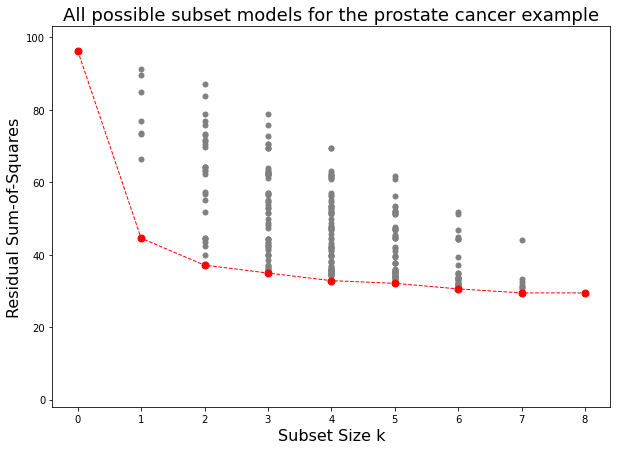

In [23]:
plt.figure(figsize=(10, 7))
plt.title('All possible subset models for the prostate cancer example', fontsize=18)
plt.plot(result_bs['num_feat'], result_bs['RSS'], 'o', color='grey', markersize=5)
plt.plot(best_subset['num_feat'], best_subset['RSS'], 'r--o', markersize=7, mfc='red', lw=1)
plt.ylim([-2, 103])
plt.xlabel('Subset Size k', fontsize=16)
plt.ylabel('Residual Sum-of-Squares', rotation=90, fontsize=16)
plt.show()

#### 3.3.2 Forward- and Backward-Stepwise Selection

##### Forward-Stepwise Selection

In [55]:
class ForwardSelection(BestSelection):
    def __init__(self, *args, **kwargs):
        super(ForwardSelection, self).__init__(*args, **kwargs)
            
    def process_subset(self):
        result = dict()
        result["num_feat"] = []
        result["feat_subset"] = []
        result["RSS"] = []
        
        subsets_remaining = list(self.subsets)
        
        subsets_keep = []
        for subset_size in range(len(self.subsets) + 1):
            subset = list(combinations(subsets_remaining, 1))

            best_RSS = np.inf
            
            if subset_size != 0:
                for feature_index in tqdm(
                    subset,
                    total=len(subset),
                    desc="processing Forward subset: {}".format(subset_size),
                ):
                    RSS_temp = self.fit(subsets_keep + list(feature_index))
                    
                    if RSS_temp < best_RSS:
                        best_RSS = RSS_temp
                        best_feature = feature_index[0]

                subsets_keep.append(best_feature)
                subsets_remaining.remove(best_feature)
                result["RSS"].append(best_RSS)
                
                subsets_keep_copy = np.sort(subsets_keep.copy())
                result["feat_subset"].append(subsets_keep_copy)
                result["num_feat"].append(subset_size)

            else:
                result["RSS"].append(self.fit(None))
                result["feat_subset"].append('intercept')
                result["num_feat"].append(0)
        
        result = pd.DataFrame(result)
        return result
    
    def get_statistics(self, result):
        result = self.get_mallow_cp(result)
        result = self.get_aic(result)
        result = self.get_bic(result)
        return result
        
        
    def get_mallow_cp(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p)) * min(result['RSS'])
        result["Mallow's Cp"] = (1 / m) * (result['RSS'] + 2 * result["num_feat"] * sigma_hat_squared) 
        return result
        
    def get_aic(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p -1)) * min(result['RSS'])
        result["AIC"] = (1 / (m * sigma_hat_squared)) * (result['RSS'] + 2 * result["num_feat"] * sigma_hat_squared) 
        return result
        
    def get_bic(self, result):
        m, p = self.x.shape
        RSS_full = min(result['RSS'])
        sigma_hat_squared = (1/(m - p -1)) * min(result['RSS'])
        result["BIC"] = (1 / (m * sigma_hat_squared)) * (result['RSS'] + np.log(m) * result["num_feat"] * sigma_hat_squared) 
        return result

In [56]:
fw_step = ForwardSelection(subsets=np.arange(x_train.shape[1]))
result_fw_step = fw_step.run(x_train, y_train)
print(result_fw_step)
print(best_subset)
print(fw_step.get_statistics(result_fw_step))

processing Forward subset: 8: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]

   num_feat               feat_subset        RSS
0         0                 intercept  96.281445
1         1                       [0]  44.528583
2         2                    [0, 1]  37.091846
3         3                 [0, 1, 4]  34.907749
4         4              [0, 1, 3, 4]  32.814995
5         5           [0, 1, 3, 4, 7]  32.069447
6         6        [0, 1, 3, 4, 5, 7]  30.539778
7         7     [0, 1, 2, 3, 4, 5, 7]  29.437300
8         8  [0, 1, 2, 3, 4, 5, 6, 7]  29.426384
     num_feat               feat_subset        RSS
0           0                 intercept  96.281445
1           1                      (0,)  44.528583
9           2                    (0, 1)  37.091846
39          3                 (0, 1, 4)  34.907749
98          4              (0, 1, 3, 4)  32.814995
175         5           (0, 1, 3, 4, 7)  32.069447
230         6        (0, 1, 3, 4, 5, 7)  30.539778
248         7     (0, 1, 2, 3, 4, 5, 7)  29.437300
255         8  (0, 1, 2, 3, 4, 5, 6, 7)  29.426384


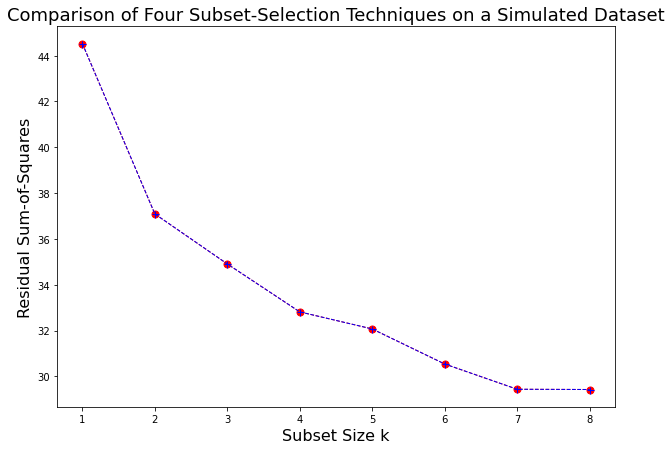

In [54]:
plt.figure(figsize=(10, 7))
plt.title('Comparison of Four Subset-Selection Techniques on a Simulated Dataset', fontsize=18)
plt.plot(best_subset['num_feat'][result_bs['num_feat'] != 0], best_subset['RSS'][result_bs['num_feat'] != 0], 'r--o', markersize=7, mfc='red', lw=1)
plt.plot(result_fw_step['num_feat'][result_fw_step['num_feat'] != 0], result_fw_step['RSS'][result_fw_step['num_feat'] != 0], 'b--+', markersize=7, mfc='blue', lw=1)
plt.xlabel('Subset Size k', fontsize=16)
plt.ylabel('Residual Sum-of-Squares', rotation=90, fontsize=16)
plt.show()

##### Backward-Stepwise Selection